Disect this code: {#property strict
#include <Trade/Trade.mqh>

CTrade trade;

// =====================
// INPUTS
// =====================
input double RiskPercent = 1.0;   // 1% risk per trade
input int    TimerSec    = 5;     // timer interval in seconds

// =====================
// GLOBALS
// =====================
string   TradeSymbol;
datetime lastEntryBarTime = 0;     // track last entry bar time
datetime lastTrailBarTime = 0;     // track last trailing bar time

double BuyInitialSL  = 0.0;       // store initial BUY SL
double SellInitialSL = 0.0;       // store initial SELL SL

// =====================
// INIT
// =====================
int OnInit()
{
   TradeSymbol = _Symbol;
   if(!SymbolSelect(TradeSymbol, true))
      return INIT_FAILED;

   EventSetTimer(TimerSec);
   return INIT_SUCCEEDED;
}

// =====================
void OnDeinit(const int reason)
{
   EventKillTimer();
}

// =====================
void OnTimer()
{
   HandleEntry();
   HandleReversal();
   HandleTrailing();
}

// ============================================================
// ENTRY LOGIC
// ============================================================
void HandleEntry()
{
   // Only one position at a time
   if(PositionSelect(TradeSymbol))
      return;

   // Get the last closed H3 candle
   datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
   if(barTime == 0 || barTime == lastEntryBarTime)
      return;

   lastEntryBarTime = barTime;

   // Confirm this is the 00:00 H3 candle close
   MqlDateTime t;
   TimeToStruct(barTime, t);
   if(t.hour != 0)
      return;

   double open  = iOpen(TradeSymbol, PERIOD_H3, 1);
   double close = iClose(TradeSymbol, PERIOD_H3, 1);
   double low   = iLow(TradeSymbol, PERIOD_H3, 1);
   double high  = iHigh(TradeSymbol, PERIOD_H3, 1);

   trade.SetDeviationInPoints(20);
   trade.SetTypeFillingBySymbol(TradeSymbol);

   // ---------------- BUY ----------------
   if(close > open)
   {
      double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);
      double sl    = low;
      double vol   = CalculateRiskVolume(entry, sl);
      if(vol > 0)
      {
         if(trade.Buy(vol, TradeSymbol, entry, sl, 0.0))
            BuyInitialSL = sl; // store initial SL
      }
   }

   // ---------------- SELL ----------------
   if(close < open)
   {
      double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
      double sl    = high;
      double vol   = CalculateRiskVolume(entry, sl);
      if(vol > 0)
      {
         if(trade.Sell(vol, TradeSymbol, entry, sl, 0.0))
            SellInitialSL = sl; // store initial SL
      }
   }
}

// ============================================================
// REVERSAL LOGIC (APPLY SPREAD × 10 RULE)
// ============================================================
void HandleReversal()
{
   double bid = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
   double ask = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);

   // ---------- BUY Reversal ----------
   if(BuyInitialSL > 0 && !PositionSelect(TradeSymbol))
   {
      if(bid <= BuyInitialSL) // BUY SL hit
      {
         datetime firstBullishBarTime = FindFirstBullishH3From0();
         if(firstBullishBarTime > 0)
         {
            int shift = iBarShift(TradeSymbol, PERIOD_H3, firstBullishBarTime);
            double sl = iHigh(TradeSymbol, PERIOD_H3, shift);

            // check spread x 10 rule
            double vol = CalculateRiskVolume(bid, sl);
            if(vol > 0)
            {
               if(trade.Sell(vol, TradeSymbol, bid, sl, 0.0))
                  BuyInitialSL = 0.0; // reset
            }
         }
      }
   }

   // ---------- SELL Reversal ----------
   if(SellInitialSL > 0 && !PositionSelect(TradeSymbol))
   {
      if(ask >= SellInitialSL) // SELL SL hit
      {
         datetime firstBearishBarTime = FindFirstBearishH3From0();
         if(firstBearishBarTime > 0)
         {
            int shift = iBarShift(TradeSymbol, PERIOD_H3, firstBearishBarTime);
            double sl = iLow(TradeSymbol, PERIOD_H3, shift);

            // check spread x 10 rule
            double vol = CalculateRiskVolume(ask, sl);
            if(vol > 0)
            {
               if(trade.Buy(vol, TradeSymbol, ask, sl, 0.0))
                  SellInitialSL = 0.0; // reset
            }
         }
      }
   }
}

// ============================================================
// TRAILING LOGIC (STRICT RULES)
// ============================================================
void HandleTrailing()
{
   if(!PositionSelect(TradeSymbol))
      return;

   // Trailing only after H3 candle closes
   datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
   if(barTime == 0 || barTime == lastTrailBarTime)
      return;

   lastTrailBarTime = barTime;

   long   type      = PositionGetInteger(POSITION_TYPE);
   double currentSL = PositionGetDouble(POSITION_SL);

   double open  = iOpen(TradeSymbol, PERIOD_H3, 1);
   double close = iClose(TradeSymbol, PERIOD_H3, 1);
   double low   = iLow(TradeSymbol, PERIOD_H3, 1);
   double high  = iHigh(TradeSymbol, PERIOD_H3, 1);

   // ---------------- BUY ----------------
   if(type == POSITION_TYPE_BUY)
   {
      if(close > open && low > currentSL)
         trade.PositionModify(TradeSymbol, low, 0.0);
   }

   // ---------------- SELL ----------------
   if(type == POSITION_TYPE_SELL)
   {
      if(close < open && high < currentSL)
         trade.PositionModify(TradeSymbol, high, 0.0);
   }
}

// ============================================================
// RISK-BASED LOT CALCULATION (APPLY SPREAD × 10 RULE)
// ============================================================
double CalculateRiskVolume(double entry, double stop)
{
   double distance = MathAbs(entry - stop);
   if(distance <= 0)
      return 0;

   // spread x 10 rule
   int spread_points = (int)SymbolInfoInteger(TradeSymbol, SYMBOL_SPREAD);
   double spread     = spread_points * SymbolInfoDouble(TradeSymbol, SYMBOL_POINT);
   if(distance < spread * 10)
      return 0;

   double balance = AccountInfoDouble(ACCOUNT_BALANCE);
   double riskAmt = balance * (RiskPercent / 100.0);

   double tickSize  = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_SIZE);
   double tickValue = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_VALUE);

   double costPerLot = (distance / tickSize) * tickValue;
   if(costPerLot <= 0)
      return 0;

   double volume = riskAmt / costPerLot;

   double minLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MIN);
   double maxLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MAX);
   double stepLot = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_STEP);

   volume = MathFloor(volume / stepLot) * stepLot;
   volume = MathMax(volume, minLot);
   volume = MathMin(volume, maxLot);

   return volume;
}

// ============================================================
// HELPER FUNCTIONS TO FIND FIRST H3 BULLISH/BEARISH BAR FROM 0:00
// ============================================================
datetime FindFirstBullishH3From0()
{
   MqlDateTime t;
   datetime today = iTime(TradeSymbol, PERIOD_D1, 0);
   TimeToStruct(today, t);
   datetime start = StructToTime(t);

   for(int i=0; i<50; i++)
   {
      datetime bar = iTime(TradeSymbol, PERIOD_H3, i);
      if(bar < start) break;
      double open  = iOpen(TradeSymbol, PERIOD_H3, i);
      double close = iClose(TradeSymbol, PERIOD_H3, i);
      if(close > open) return bar;
   }
   return 0;
}

datetime FindFirstBearishH3From0()
{
   MqlDateTime t;
   datetime today = iTime(TradeSymbol, PERIOD_D1, 0);
   TimeToStruct(today, t);
   datetime start = StructToTime(t);

   for(int i=0; i<50; i++)
   {
      datetime bar = iTime(TradeSymbol, PERIOD_H3, i);
      if(bar < start) break;
      double open  = iOpen(TradeSymbol, PERIOD_H3, i);
      double close = iClose(TradeSymbol, PERIOD_H3, i);
      if(close < open) return bar;
   }
   return 0;
}
}, if it truly is, and by simply following this new trading-logic: {The following logic is strictly only for H3 candles, three-hour interval bars. {  

Original entry: {If the '0:00 am to 3:00 am H3 bar' is bullish, then market-buy exactly at its close (3:00 am). The 'initial stop-loss' is at the low of '0:00 am to 3:00 am H3 bar'. Do not enter the trade if the initial-stoploss distance is less than the (corresponding symbol's spread x 10) distance. Risking 1% on the trade, accounting for the full stop-loss distance. The take-profit will depend on the stop-loss trailing mechanism. The stoploss will only trail at every preceding 'bullish H3 candle's low, skipping the bearish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited to the number of candles; it can run infinitely.} 

Reverse entry: {If the 'Original entry' closed (stopped out) at negative stoploss (initial-stoploss or trailed-stoploss as long as it's not in profit), then 'market-sell exactly at the stop out price'. Locate the position -1 candle's high and place the 'initial-stoploss' there. Do not enter the trade if the initial-stoploss distance is less than the (corresponding symbol's spread x 10) distance. And also, risking 1% on the trade, accounting for the full stop-loss distance. And also, the take-profit will depend on the stop-loss trailing mechanism. And also, the stoploss will only trail at every preceding 'bearish H3 candle's high', skipping the bullish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited to the number of candles; it can run infinitely.} 

And on the other side,

Original entry: {If the '0:00 am to 3:00 am H3 bar' is bearish, then market-sell exactly at its close (3:00 am). The 'initial stop-loss' is at the high of '0:00 am to 3:00 am H3 bar'. Do not enter the trade if the initial-stoploss distance is less than the (corresponding symbol's spread x 10) distance. Risking 1% on the trade, accounting for the full stop-loss distance. The take-profit will depend on the stop-loss trailing mechanism. The stoploss will only trail at every preceding 'bearish H3 candle's high, skipping the bullish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited tothe  number of candles; it can run infinitely.} 

Reverse entry: {If the 'Original entry' closed (stopped out) at negative stoploss (initial-stoploss or trailed-stoploss as long as it's not in profit), then 'market-buy exactly at the stop out price'. Locate the position -1 candle's low and place the 'initial-stoploss' there. Do not enter the trade if the initial-stoploss distance is less than the (corresponding symbol's spread x 10) distance. And also, risking 1% on the trade, accounting for the full stop-loss distance. And also, the take-profit will depend on the stop-loss trailing mechanism. And also, the stoploss will only trail at every preceding 'bullish H3 candle's low, skipping the bearish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited to the number of candles; it can run infinitely.} 

Final note for all entry types: There will be a maximum of one type of original-entry and a maximum of one type of reverse entry inside its corresponding day. 

}}

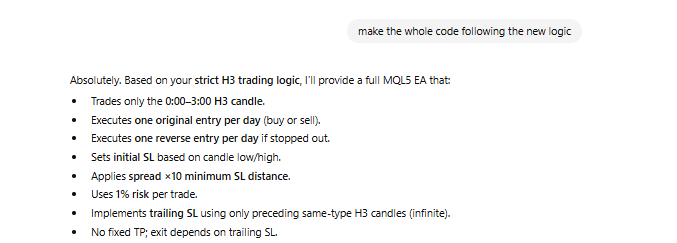

In [ ]:
#property strict
#include <Trade/Trade.mqh>

CTrade trade;

// =====================
// INPUTS
// =====================
input double RiskPercent = 1.0;   // 1% risk per trade
input int    TimerSec    = 5;     // timer interval in seconds

// =====================
// GLOBALS
// =====================
string   TradeSymbol;
datetime lastEntryBarTime   = 0; // track last original entry bar
datetime lastTrailBarTime   = 0; // track last trailing bar
bool     originalEntryDone  = false; // flag for original entry per day
bool     reverseEntryDone   = false; // flag for reverse entry per day
double   initialSL          = 0.0;   // store initial SL

// =====================
// INIT
// =====================
int OnInit()
{
    TradeSymbol = _Symbol;
    if(!SymbolSelect(TradeSymbol, true))
        return INIT_FAILED;

    EventSetTimer(TimerSec);
    return INIT_SUCCEEDED;
}

// =====================
void OnDeinit(const int reason)
{
    EventKillTimer();
}

// =====================
void OnTimer()
{
    ResetFlags();      // reset daily flags if new day
    HandleEntry();
    HandleReverseEntry();
    HandleTrailing();
}

// ============================================================
// ORIGINAL ENTRY LOGIC
// ============================================================
void HandleEntry()
{
    if(PositionSelect(TradeSymbol) || originalEntryDone)
        return;

    datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
    if(barTime == 0 || barTime == lastEntryBarTime)
        return;

    lastEntryBarTime = barTime;

    MqlDateTime t;
    TimeToStruct(barTime, t);
    if(t.hour != 0) // only 0:00–3:00 H3 candle
        return;

    double open  = iOpen(TradeSymbol, PERIOD_H3, 1);
    double close = iClose(TradeSymbol, PERIOD_H3, 1);
    double low   = iLow(TradeSymbol, PERIOD_H3, 1);
    double high  = iHigh(TradeSymbol, PERIOD_H3, 1);

    trade.SetDeviationInPoints(20);
    trade.SetTypeFillingBySymbol(TradeSymbol);

    // ---------------- BUY ----------------
    if(close > open)
    {
        double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);
        double sl    = low;
        double vol   = CalculateRiskVolume(entry, sl);
        if(vol > 0)
        {
            if(trade.Buy(vol, TradeSymbol, entry, sl, 0.0))
            {
                initialSL = sl;
                originalEntryDone = true;
            }
        }
    }

    // ---------------- SELL ----------------
    if(close < open)
    {
        double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
        double sl    = high;
        double vol   = CalculateRiskVolume(entry, sl);
        if(vol > 0)
        {
            if(trade.Sell(vol, TradeSymbol, entry, sl, 0.0))
            {
                initialSL = sl;
                originalEntryDone = true;
            }
        }
    }
}

// ============================================================
// REVERSE ENTRY LOGIC
// ============================================================
void HandleReverseEntry()
{
    if(PositionSelect(TradeSymbol) || !originalEntryDone || reverseEntryDone)
        return;

    double bid = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
    double ask = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);

    if(initialSL == 0.0)
        return;

    // Previous H3 candle (-2)
    double prevOpen  = iOpen(TradeSymbol, PERIOD_H3, 2);
    double prevClose = iClose(TradeSymbol, PERIOD_H3, 2);
    double prevLow   = iLow(TradeSymbol, PERIOD_H3, 2);
    double prevHigh  = iHigh(TradeSymbol, PERIOD_H3, 2);

    // ---------------- BUY Reverse ----------------
    if(bid <= initialSL && iClose(TradeSymbol, PERIOD_H3, 1) < iOpen(TradeSymbol, PERIOD_H3, 1))
    {
        double sl = prevHigh;
        double vol = CalculateRiskVolume(bid, sl);
        if(vol > 0)
        {
            if(trade.Sell(vol, TradeSymbol, bid, sl, 0.0))
            {
                initialSL = sl;
                reverseEntryDone = true;
            }
        }
    }

    // ---------------- SELL Reverse ----------------
    if(ask >= initialSL && iClose(TradeSymbol, PERIOD_H3, 1) > iOpen(TradeSymbol, PERIOD_H3, 1))
    {
        double sl = prevLow;
        double vol = CalculateRiskVolume(ask, sl);
        if(vol > 0)
        {
            if(trade.Buy(vol, TradeSymbol, ask, sl, 0.0))
            {
                initialSL = sl;
                reverseEntryDone = true;
            }
        }
    }
}

// ============================================================
// TRAILING LOGIC
// ============================================================
void HandleTrailing()
{
    if(!PositionSelect(TradeSymbol))
        return;

    datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
    if(barTime == 0 || barTime == lastTrailBarTime)
        return;

    lastTrailBarTime = barTime;

    long type = PositionGetInteger(POSITION_TYPE);
    double currentSL = PositionGetDouble(POSITION_SL);

    double open  = iOpen(TradeSymbol, PERIOD_H3, 1);
    double close = iClose(TradeSymbol, PERIOD_H3, 1);
    double low   = iLow(TradeSymbol, PERIOD_H3, 1);
    double high  = iHigh(TradeSymbol, PERIOD_H3, 1);

    // ---------------- BUY ----------------
    if(type == POSITION_TYPE_BUY)
    {
        if(close > open && low > currentSL)
            trade.PositionModify(TradeSymbol, low, 0.0);
    }

    // ---------------- SELL ----------------
    if(type == POSITION_TYPE_SELL)
    {
        if(close < open && high < currentSL)
            trade.PositionModify(TradeSymbol, high, 0.0);
    }
}

// ============================================================
// RISK-BASED LOT CALCULATION
// ============================================================
double CalculateRiskVolume(double entry, double stop)
{
    double distance = MathAbs(entry - stop);
    if(distance <= 0)
        return 0;

    // spread x 10 rule
    int spread_points = (int)SymbolInfoInteger(TradeSymbol, SYMBOL_SPREAD);
    double spread     = spread_points * SymbolInfoDouble(TradeSymbol, SYMBOL_POINT);
    if(distance < spread * 10)
        return 0;

    double balance = AccountInfoDouble(ACCOUNT_BALANCE);
    double riskAmt = balance * (RiskPercent / 100.0);

    double tickSize  = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_SIZE);
    double tickValue = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_VALUE);

    double costPerLot = (distance / tickSize) * tickValue;
    if(costPerLot <= 0)
        return 0;

    double volume = riskAmt / costPerLot;

    double minLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MIN);
    double maxLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MAX);
    double stepLot = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_STEP);

    volume = MathFloor(volume / stepLot) * stepLot;
    volume = MathMax(volume, minLot);
    volume = MathMin(volume, maxLot);

    return volume;
}

// ============================================================
// DAILY RESET OF FLAGS
// ============================================================
void ResetFlags()
{
    static datetime lastResetTime = 0;
    datetime now = TimeCurrent();
    MqlDateTime t;
    TimeToStruct(now, t);

    // Reset once per day at 0:00 H3 candle
    if(t.hour == 0 && lastResetTime < now - 3600) // ensure reset only once
    {
        originalEntryDone = false;
        reverseEntryDone  = false;
        initialSL         = 0.0;
        lastResetTime = now;
    }
}


For every sell entries, make sure you trail the stoploss only after the closed bar of bearish H3 candles, place it at the high of the closed bar, and skip the bullish closed bars.  For every buy entry, make sure you trail the stoploss only after the closed bar of bullish H3 candles, place it at the low of the closed bar, and skip the bearish closed bars.

#property strict
#include <Trade/Trade.mqh>

CTrade trade;

// =====================
// INPUTS
// =====================
input double RiskPercent = 1.0;   // 1% risk per trade
input int    TimerSec    = 5;     // timer interval in seconds

// =====================
// GLOBALS
// =====================
string   TradeSymbol;
datetime lastEntryBarTime   = 0; // track last original entry bar
datetime lastTrailBarTime   = 0; // track last trailing bar
bool     originalEntryDone  = false; // flag for original entry per day
bool     reverseEntryDone   = false; // flag for reverse entry per day
double   initialSL          = 0.0;   // store initial SL

// =====================
// INIT
// =====================
int OnInit()
{
    TradeSymbol = _Symbol;
    if(!SymbolSelect(TradeSymbol, true))
        return INIT_FAILED;

    EventSetTimer(TimerSec);
    return INIT_SUCCEEDED;
}

// =====================
void OnDeinit(const int reason)
{
    EventKillTimer();
}

// =====================
void OnTimer()
{
    ResetFlags();      // reset daily flags if new day
    HandleEntry();
    HandleReverseEntry();
    HandleTrailing();
}

// ============================================================
// ORIGINAL ENTRY LOGIC
// ============================================================
void HandleEntry()
{
    if(PositionSelect(TradeSymbol) || originalEntryDone)
        return;

    datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
    if(barTime == 0 || barTime == lastEntryBarTime)
        return;

    lastEntryBarTime = barTime;

    MqlDateTime t;
    TimeToStruct(barTime, t);
    if(t.hour != 0) // only 0:00–3:00 H3 candle
        return;

    double open  = iOpen(TradeSymbol, PERIOD_H3, 1);
    double close = iClose(TradeSymbol, PERIOD_H3, 1);
    double low   = iLow(TradeSymbol, PERIOD_H3, 1);
    double high  = iHigh(TradeSymbol, PERIOD_H3, 1);

    trade.SetDeviationInPoints(20);
    trade.SetTypeFillingBySymbol(TradeSymbol);

    // ---------------- BUY ----------------
    if(close > open)
    {
        double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);
        double sl    = low;
        double vol   = CalculateRiskVolume(entry, sl);
        if(vol > 0)
        {
            if(trade.Buy(vol, TradeSymbol, entry, sl, 0.0))
            {
                initialSL = sl;
                originalEntryDone = true;
            }
        }
    }

    // ---------------- SELL ----------------
    if(close < open)
    {
        double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
        double sl    = high;
        double vol   = CalculateRiskVolume(entry, sl);
        if(vol > 0)
        {
            if(trade.Sell(vol, TradeSymbol, entry, sl, 0.0))
            {
                initialSL = sl;
                originalEntryDone = true;
            }
        }
    }
}

// ============================================================
// REVERSE ENTRY LOGIC
// ============================================================
void HandleReverseEntry()
{
    if(PositionSelect(TradeSymbol) || !originalEntryDone || reverseEntryDone)
        return;

    double bid = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
    double ask = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);

    if(initialSL == 0.0)
        return;

    // Previous H3 candle (-2)
    double prevOpen  = iOpen(TradeSymbol, PERIOD_H3, 2);
    double prevClose = iClose(TradeSymbol, PERIOD_H3, 2);
    double prevLow   = iLow(TradeSymbol, PERIOD_H3, 2);
    double prevHigh  = iHigh(TradeSymbol, PERIOD_H3, 2);

    // ---------------- BUY Reverse ----------------
    if(bid <= initialSL && iClose(TradeSymbol, PERIOD_H3, 1) < iOpen(TradeSymbol, PERIOD_H3, 1))
    {
        double sl = prevHigh;
        double vol = CalculateRiskVolume(bid, sl);
        if(vol > 0)
        {
            if(trade.Sell(vol, TradeSymbol, bid, sl, 0.0))
            {
                initialSL = sl;
                reverseEntryDone = true;
            }
        }
    }

    // ---------------- SELL Reverse ----------------
    if(ask >= initialSL && iClose(TradeSymbol, PERIOD_H3, 1) > iOpen(TradeSymbol, PERIOD_H3, 1))
    {
        double sl = prevLow;
        double vol = CalculateRiskVolume(ask, sl);
        if(vol > 0)
        {
            if(trade.Buy(vol, TradeSymbol, ask, sl, 0.0))
            {
                initialSL = sl;
                reverseEntryDone = true;
            }
        }
    }
}

// ============================================================
// TRAILING LOGIC (STRICT BULLISH/BEARISH RULE)
// ============================================================
void HandleTrailing()
{
    if(!PositionSelect(TradeSymbol))
        return;

    datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
    if(barTime == 0 || barTime == lastTrailBarTime)
        return;

    lastTrailBarTime = barTime;

    long type = PositionGetInteger(POSITION_TYPE);
    double currentSL = PositionGetDouble(POSITION_SL);

    double open  = iOpen(TradeSymbol, PERIOD_H3, 1);
    double close = iClose(TradeSymbol, PERIOD_H3, 1);
    double low   = iLow(TradeSymbol, PERIOD_H3, 1);
    double high  = iHigh(TradeSymbol, PERIOD_H3, 1);

    // ---------------- BUY ----------------
    if(type == POSITION_TYPE_BUY)
    {
        // Only trail after bullish candle
        if(close > open && low > currentSL)
            trade.PositionModify(TradeSymbol, low, 0.0);
    }

    // ---------------- SELL ----------------
    if(type == POSITION_TYPE_SELL)
    {
        // Only trail after bearish candle
        if(close < open && high < currentSL)
            trade.PositionModify(TradeSymbol, high, 0.0);
    }
}

// ============================================================
// RISK-BASED LOT CALCULATION
// ============================================================
double CalculateRiskVolume(double entry, double stop)
{
    double distance = MathAbs(entry - stop);
    if(distance <= 0)
        return 0;

    // spread x 10 rule
    int spread_points = (int)SymbolInfoInteger(TradeSymbol, SYMBOL_SPREAD);
    double spread     = spread_points * SymbolInfoDouble(TradeSymbol, SYMBOL_POINT);
    if(distance < spread * 10)
        return 0;

    double balance = AccountInfoDouble(ACCOUNT_BALANCE);
    double riskAmt = balance * (RiskPercent / 100.0);

    double tickSize  = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_SIZE);
    double tickValue = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_VALUE);

    double costPerLot = (distance / tickSize) * tickValue;
    if(costPerLot <= 0)
        return 0;

    double volume = riskAmt / costPerLot;

    double minLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MIN);
    double maxLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MAX);
    double stepLot = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_STEP);

    volume = MathFloor(volume / stepLot) * stepLot;
    volume = MathMax(volume, minLot);
    volume = MathMin(volume, maxLot);

    return volume;
}

// ============================================================
// DAILY RESET OF FLAGS
// ============================================================
void ResetFlags()
{
    static datetime lastResetTime = 0;
    datetime now = TimeCurrent();
    MqlDateTime t;
    TimeToStruct(now, t);

    // Reset once per day at 0:00 H3 candle
    if(t.hour == 0 && lastResetTime < now - 3600) // ensure reset only once
    {
        originalEntryDone = false;
        reverseEntryDone  = false;
        initialSL         = 0.0;
        lastResetTime = now;
    }
}


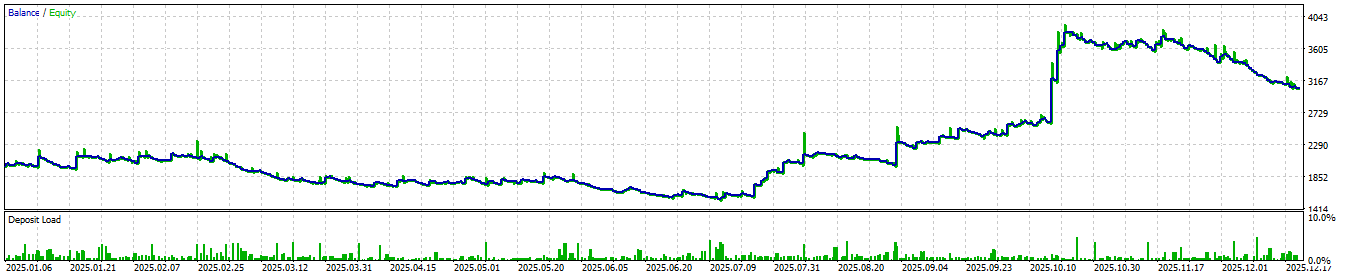

Never move a stoploss if the current bar H3 is not closed 


The reverse-entry should never be the same order type as the original-entry (for example, if the original-entry was a buy, then the reverse-entry shouldbe  a sell)